In [1]:
from cbayes import sample
from cbayes import distributions
from cbayes import solve
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
import scipy.stats as sstats
import ipywidgets as wid

In [2]:
%matplotlib inline

In [3]:
plt.rcParams['font.size'] = 18

In [66]:
##### FIXED PARAMETERS - DEFINE YOUR EXPERIMENT #####
num_observations = 50 # how many observations are you able to make?
start_time = 0.25
end_time = 5


# TRUE PARAMETERS
initial_condition_0 = 0.25
decay_rate_0 = 0.5
frequency_0 = 0.0
####

def makemodel(t):
    num_obs = len(t)
    t = t.reshape(1,-1)
    def model(lam = None):
        if lam is None: 
            lam = np.zeros((1,num_obs+3))
            lam[:,0] = initial_condition_0
            lam[:,1] = decay_rate_0
            lam[:,2] = frequency_0
        initial_condition = lam[:,0].reshape(-1,1)
        decay_rate = lam[:,1].reshape(-1,1)
        frequency = lam[:,2].reshape(-1,1)
        noise = lam[:,3::]
        QoI = initial_condition*np.exp(-decay_rate*t)
        QoI *= np.cos(np.multiply(0.5*frequency*t, 2*np.pi))
        QoI -= noise
        if QoI.shape[0] == 1:
            return QoI.reshape(1,-1) # this allows support for simpler 1D plotting.
        else:
            return QoI
    return model


t = np.linspace(start_time, end_time, num_observations)
ed_model = makemodel(t)

u = ed_model()

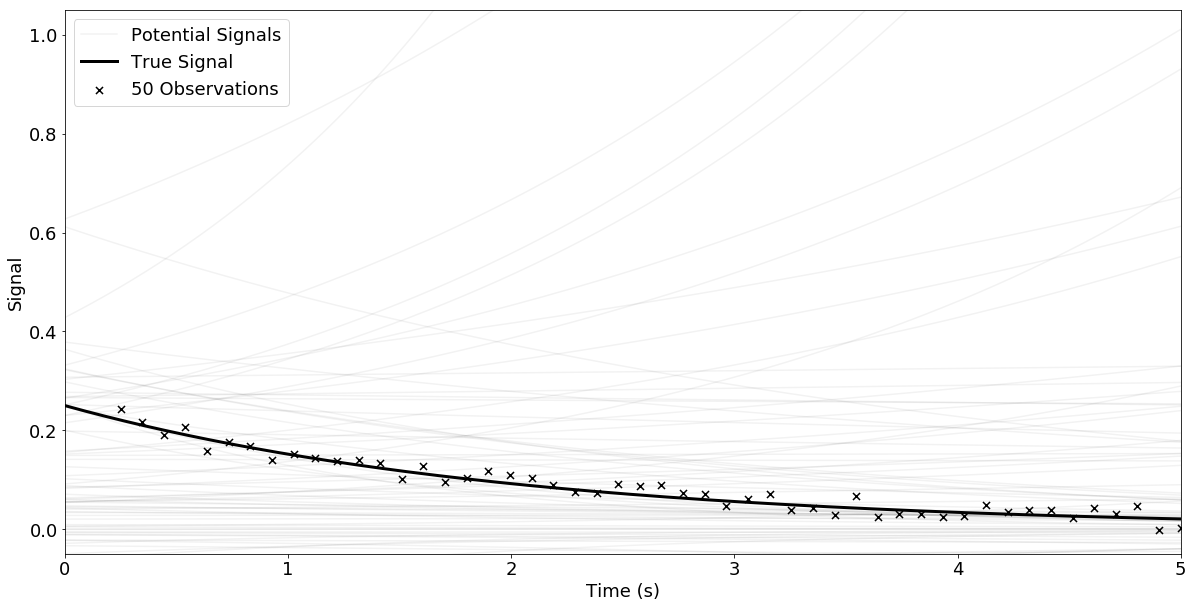

In [74]:
n = 100

# REFERENCE SIGNAL 
sd_test_n = 5E-2
# sd_test_u = 0.05


# lam[:,1]*= 0.25*0


mintime = 0
maxtime = 5
ns = 500 # fine-scaled plotting
tt = np.linspace(mintime, maxtime, ns)

# NOISELESS POSSIBITIES
m = makemodel(tt)
lamf = np.random.randn(n,3+ns)*0.25
lamf[:,3::] = 0 # no noise (graphing only)
# lamf[:,0] = initial_condition_0
# lamf[:,1] = decay_rate_0
lamf[:,2] = frequency_0

ui = m(lamf)
plt.figure(figsize=(20,10))
plt.cla()
show_obs = True
# Plotting the default IR results from the epidemic_IR function.
for i in range(n):
    d = ui[i,:]
    if i == n-1:
        plt.plot(tt, d, c='k', alpha=5/n, label='Potential Signals')
    else:
        plt.plot(tt, d, c='k', alpha=5/n) # I

um = m()
plt.plot(tt, um.ravel(), c='k', lw=3, ls='-', label='True Signal')

lam = np.random.random(size=(1,3+num_observations))
lam[:,3::] *= sd_test_n
lam[:,3::] -= sd_test_n/2
lam[:,0] = initial_condition_0
lam[:,1] = decay_rate_0
lam[:,2] = frequency_0
if show_obs:
    plt.scatter(t, ed_model(lam), marker='x', s=50, c='k', label='{} Observations'.format(num_observations), alpha=1)

plt.legend(fontsize=18,loc='upper left')
plt.ylabel('Signal', fontsize=18)
plt.xlabel('Time (s)', fontsize=18)
plt.ylim([-.05,1.05])
plt.xlim([0,5])

# ftype = 'png'
# if show_obs:
#     summary_save_str = "saveimgs/HO/HO_%d_r-%d_obs-%de-3_sd-t_%d_%d_st%d_%d.%s"%(n, num_observations, 1000*sd_test_n, mintime, maxtime, start_time, end_time, ftype)
# else:
#     summary_save_str = "saveimgs/HO/HO_signal-%d_t_%d_%d_st%d_%d.%s"%(n, mintime, maxtime, start_time, end_time, ftype)

# print("saving " + summary_save_str)
# plt.savefig(summary_save_str)
plt.show()

In [77]:
data_std = 1E-2
prior_std = 0.25

# data_std = 0.1
# prior_std = 0.25

N = 10000
M = num_observations
model = ed_model

lam_true = np.zeros((1,M+3)).reshape(1,-1) # zero noise
lam_true[:,0] = initial_condition_0
lam_true[:,1] = decay_rate_0
lam_true[:,2] = frequency_0

obs_data = model( lam_true ).ravel() # here "observed data" is noiseless because of the way the model is defined with the noise as part of the input parameter space.
def loss_fun(output_samples):
    return (1./data_std)*(1./np.sqrt(M))*np.sum( output_samples - obs_data, axis=1)

np.random.seed(1865) #7146



initial_dist_lam = sstats.distributions.norm(scale=prior_std, loc=0)
initial_dist_eps = sstats.distributions.norm(scale=[data_std for _ in range(M)], loc=0)

input_samples = np.zeros((N,M+3))
input_samples[:, 0:3] = initial_dist_lam.rvs(size=(N,3))
input_samples[:, 3::] = initial_dist_eps.rvs(size=(N,M))
# input_samples[:,0] = initial_condition_0
# input_samples[:,1] = decay_rate_0
input_samples[:,2] = frequency_0


# print('data:', obs_data)

output_samps = model(input_samples) # model evaluations
output_samples = loss_fun(output_samps) # pass through loss function


obs_dist = sstats.distributions.norm()

def pf_initial_dist_PDF(x):
    pf_dist = sstats.gaussian_kde(output_samples)
    return pf_dist.evaluate(x)
#     a, l, s = sstats.distributions.gamma.fit(output_samples,floc=0)
#     fit = sstats.distributions.gamma(a=a,loc=l,scale=s)
#     return fit.pdf(x)

def initial_dist_PDF(x):
    lam = x[:,0:3]
    eps = x[:,3::]
    lam_pdf = np.product(initial_dist_lam.pdf(lam),axis=1)
    eps_pdf = np.product(initial_dist_eps.pdf(eps),axis=1)
    return lam_pdf*eps_pdf
    
def eval_updated(x):
    y = loss_fun(model(x))
    r = np.divide(obs_dist.pdf(y), pf_initial_dist_PDF(y))
    return  initial_dist_PDF(x)*r, r

pf_eval = pf_initial_dist_PDF(output_samples)
obs_eval = obs_dist.pdf(output_samples)

ratio = np.divide(obs_eval, pf_eval)


print('ratio mean', ratio.mean())
rn = np.random.rand(N)
accepted_inds = [i for i in range(N) if ratio[i] > rn[i]]
num_accepted = len(accepted_inds)
print('%d accepted, %2.2f%%'%(num_accepted, 100*num_accepted/N))

eval_initial_lam = np.product(initial_dist_lam.pdf(input_samples[:,0:3]),axis=1)
eval_initial_eps = np.product(initial_dist_eps.pdf(input_samples[:,3::]),axis=1)
updated_dist = eval_initial_lam*eval_initial_eps*ratio

ratio mean 1.04898368161
135 accepted, 1.35%


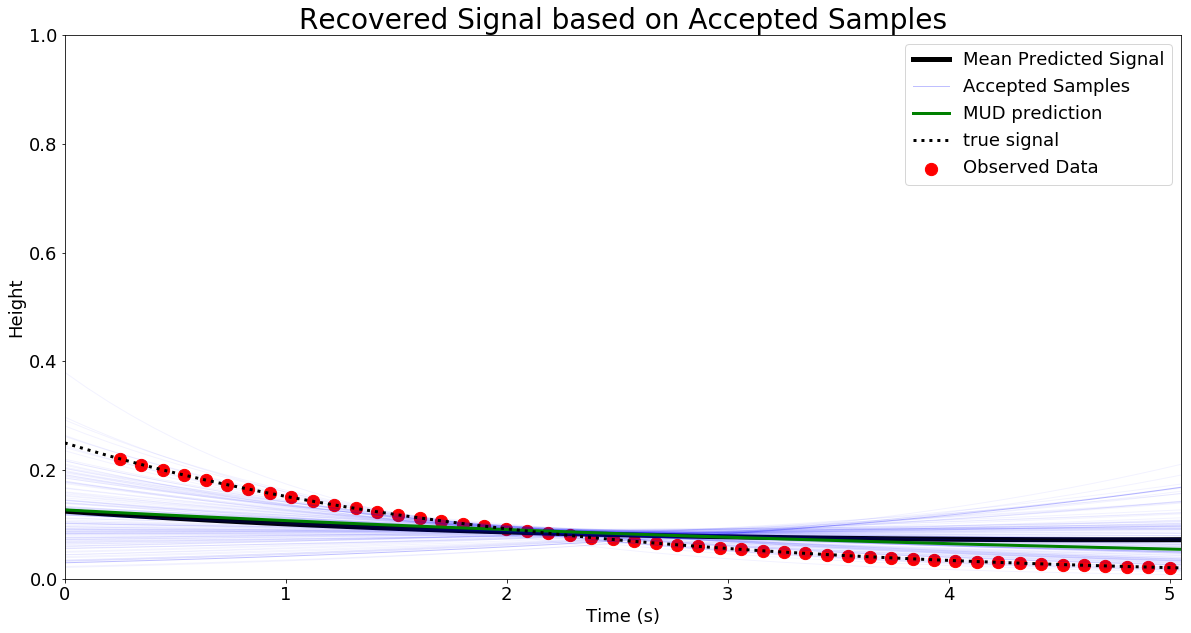

In [78]:
kk = 100 
I = np.zeros((num_accepted, 3+kk))
I[:,0:3] = input_samples[accepted_inds,0:3]
t = np.linspace(start_time, end_time, M)
tt = np.linspace(0, 10, kk)
m = makemodel(tt)
u_acc = m(I)


plt.figure(figsize=(20,10))

dd = np.mean(u_acc, axis=0)
plt.plot(tt, dd, c='k', alpha=1, lw=5, label='Mean Predicted Signal')

for i in range(np.minimum(1000,num_accepted)):
    d = u_acc[i,:]
    if i==1:
        plt.plot(tt, d, c='b', alpha=0.25, lw=1, label='Accepted Samples')
    else:
        plt.plot(tt, d, c='b', alpha=0.05, lw=1)

plt.scatter(t, obs_data, marker='o', c='r', s=150, alpha=1, label='Observed Data')
max_input_sample_index = np.where(updated_dist == np.max(updated_dist))
mud_pt = np.zeros((1,kk+3))
mud_pt[:,0:3] = input_samples[max_input_sample_index,0:3]
plt.plot(tt, m(mud_pt).ravel(), c='green', lw=3, label='MUD prediction')
plt.plot(tt, m().ravel(), ls=':', c='k', lw=3, label='true signal')

plt.ylabel('Height', fontsize=18)
plt.xlabel('Time (s)', fontsize=18)
plt.title('Recovered Signal based on Accepted Samples', fontsize=28)
plt.legend(fontsize=18, loc='upper left')
plt.xlim([0,5+.05])
plt.ylim([0,1])
# plt.hlines(np.mean(I),0,5)
problem = 'full'
# plt.savefig('recovered{}.png'.format(problem.upper()))
plt.legend()
plt.show()

In [55]:
input_samples[max_input_sample_index,:]

array([[[ -3.84203450e-01,  -9.53649252e-02,   3.92925156e-01,
           4.08576093e-02,  -2.91302438e-02,   3.25892939e-02,
          -7.28232502e-03,  -4.88503161e-02,  -3.51595601e-02,
           2.85819190e-02,  -2.04933441e-02,  -3.98799295e-02,
          -3.57631633e-02,   2.82037747e-02,   1.31922847e-02,
           7.27239973e-03,   1.75414462e-02,   2.61113546e-02,
           6.81040295e-03,   2.70372863e-02,  -4.97828235e-02,
           7.62407688e-02,   3.46875220e-02,  -1.52856846e-02,
          -2.61823893e-02,   5.58572525e-02,   1.78741369e-02,
           4.79178553e-02,  -5.98452252e-03,   3.58053014e-02,
           2.83694832e-03,  -5.00169925e-05,  -1.45195605e-02,
           3.72047591e-02,   1.20534871e-02,  -4.26578256e-02,
           1.61782033e-02,   7.99097674e-03,   6.61894393e-02,
           2.76429054e-02,   2.28775344e-02,   2.50858225e-02,
           3.50382913e-02,   4.82514051e-02,   7.51193728e-02,
          -1.38078799e-02,   3.98199242e-03,   1.524342

In [ ]:
# dim_slice_num = 2

def wrap(dim_slice_num = 0, noise_slice_obs_num = 1, noise_idx=0): # which of the three input paramaters do you want to use for the x-axis?
     # which observation do you want to condition on? (use for y-axis)
    ns = 25


    eval_L = np.linspace(-prior_std, prior_std, ns) 
    eval_E = np.linspace(-2*data_std, 2*data_std, ns)
#     eval_L = np.linspace(0, prior_std, ns) 
    # eval_E = np.linspace(-data_std/2, data_std/2, ns)

    eval_pts = np.meshgrid(eval_L, eval_E)

    eval_points = np.zeros((ns*ns, M+3))
    eval_points[:,0] = initial_condition_0
    eval_points[:,1] = decay_rate_0
    eval_points[:,2] = frequency_0
    #     for ds in range(3): # evaluation mesh on all three
    #         eval_points[:,ds] = eval_pts[0].ravel()
    eval_points[:,dim_slice_num] = eval_pts[0].ravel()
    
    if noise_idx > 0:
        eval_points[:,3::] = (input_samples[noise_idx-1,3::].reshape(-1,1)@eval_pts[1].reshape(1,-1)).T#.ravel() # condition on SOME potential realization of noise

#     eval_points[:,2+noise_slice_obs_num] = input_samples[noise_idx-1,2+noise_slice_obs_num] # or just in one index
#     eval_points[:,2+noise_slice_obs_num] = eval_pts[1].ravel() # and then allow one of the observational noises to vary
    # eval_points[:,1] = 0.01
    
#     for idx in range(0,2+noise_slice_obs_num):
#         eval_points[:,idx] = eval_pts[1].ravel()

    L = eval_pts[0].reshape(ns,ns)
    E = eval_pts[1].reshape(ns,ns)


    post_eval, ratio_full = eval_updated(eval_points)
    post_eval = post_eval.reshape(ns,ns)
#     if noise_idx > 0:
#         post_eval = post_eval/5E18
#     else:
#         post_eval = post_eval/5E14
    # eval_points
    plt.figure(figsize=(10,10))
#     levels=[m*post_eval.max() for m in np.linspace(0.5,1,2)]
    plt.contourf(L, E, post_eval, vmin=0, vmax=None)
#     print(post_eval.max())
    # plt.vlines(obs_data[0],-.5, .5,alpha=0.5)
    # plt.vlines(0,-.5, .5,alpha=0.5)

    noise = 0*np.random.randn(num_observations)*data_std # generate ONE realization of noise
    # print('noise:', noise)
    plt.scatter([lam_true[0,dim_slice_num]],[[0]], color='black', s=150)
    plt.scatter([lam_true[0,dim_slice_num]],[[0]], color='white', s=50, label='true lambda')
    # plt.scatter(accepted_inputs[:,0], accepted_inputs[:,1])
    plt.legend()

    
    # plt.scatter(o[:,0], o[:,1])
    # plt.plot([-2*data_std+lam,2*data_std+lam], [-2*data_std,2*data_std], 'white', alpha=0.3)

    # plt.axis('equal')5
    # plt.savefig('ZZtestpost.png')]

    def conditional(input_values, dim=dim_slice_num, fix_noise = 0):
        # fix_noise can be a vector of length `num_observations`
        a = np.zeros((1,M+3))
        a[:,0] = initial_condition_0
        a[:,1] = decay_rate_0
        a[:,2] = frequency_0
        a[:,3::] = fix_noise
        a[:,dim] = input_values
        return eval_updated(a)[0]



    # I = quad(conditional, -1, 1, args=[0,0])
    # # I = quad(conditionalX, -2*data_std, 2*data_std, args=lam-1E-8)
    # plt.hlines(noise[noise_slice_obs_num-1], -prior_std + obs_data, prior_std + obs_data, label='data $\pm 0.05\sigma_\lambda$')

    # print('integral of conditional on noise:', I[0], 'error:', I[1])
    plt.show()

In [ ]:
wid.interact(wrap, dim_slice_num = wid.IntSlider(min=0, max=2, continuous_update=False), 
             noise_slice_obs_num = wid.IntSlider(min=1, max=M, continuous_update=False),
            noise_idx=wid.IntSlider(value=10, min=0, max=N, continuous_update=False)
            )

## See differences in Pushforwards when you fix noise values

Exploring the "corners" of the M-dimensional Guassian hyper-sphere to get a sense of bounds on the noise sample space.

In [ ]:
def see_difference(eps,idx):
    i0, i1 = idx
    input_samples_fix_noise = input_samples.copy()
    input_samples_fix_noise[:,i0:(i1+0)] = eps
    output_samps_fix_noise = model(input_samples_fix_noise)
    output_samples_fix_noise = loss_fun(output_samps_fix_noise)
    
    w = 3 # window size (to the left and right of zero)
    plt.figure(figsize=(20,10))
    plt.hist(output_samples, bins=40, density=True, color='b', alpha = 0.5, label='histogram of loss function for variable noise')
    plt.hist(output_samples_fix_noise, bins=40, density=True, alpha = 0.5, color='r', label='histogram of loss function for fixed noise')
    xmesh = np.linspace(-w, w, 1000)
    full_eval = sstats.gaussian_kde(output_samples).evaluate(xmesh)
    part_eval = sstats.gaussian_kde(output_samples_fix_noise).evaluate(xmesh)
    plt.plot(xmesh, full_eval, c='b', label='estimate of density for full problem', lw=3)
#     plt.vlines(0,0, 0.3)
    plt.plot(xmesh, part_eval, c='r', label='estimate of density for approx problem', lw=3)
#     plt.plot(xmesh, obs_dist.pdf(xmesh), 'k:', label='observed')
    plt.title('Data Space')
    plt.xlim([-w, w])
#     plt.ylim([0, 0.1])
    plt.legend()
    plt.show()
    ratio_diff = np.abs( (full_eval - part_eval)/full_eval )
    print(ratio_diff.min(), ratio_diff.max())
    print(100*ratio_diff.mean(), ratio_diff.std())
    print(output_samples_fix_noise.min(), output_samples_fix_noise.max())
    print(output_samples.min(), output_samples.max())
    
eps_choice = list(np.linspace(-0.025, 0.025, 5))
wid.interact(see_difference, eps=wid.SelectionSlider(value=0, options=eps_choice, continuous_update=False),
             idx=wid.IntRangeSlider(value=(3,M+1), min=3, max=M+1, continuous_update=False),
            regularize=wid.Checkbox(value=True))


## Draw random samples from $\Xi$ and approximate push-forward

In [ ]:
def see_variation(k,idx):
    i0, i1 = idx
    input_samples_fix_noise = input_samples.copy()
    input_samples_fix_noise[:,i0:i1] = input_samples_fix_noise[k,i0:i1]
    
    output_samps_fix_noise = model(input_samples_fix_noise)
    output_samples_fix_noise = loss_fun(output_samps_fix_noise)
    
    w = 5 # window size (to the left and right of zero)
    plt.figure(figsize=(20,10))
    plt.hist(output_samples, bins=40, density=True, color='b', alpha = 0.5, label='histogram of loss function for variable noise')
    plt.hist(output_samples_fix_noise, bins=40, density=True, alpha = 0.5, color='r', label='histogram of loss function for fixed noise')
    xmesh = np.linspace(-w, w, 1000)
    full_eval = sstats.gaussian_kde(output_samples).evaluate(xmesh)
    part_eval = sstats.gaussian_kde(output_samples_fix_noise).evaluate(xmesh)
    plt.plot(xmesh, full_eval, c='b', label='estimate of density for full problem', lw=3)
#     plt.vlines(0,0, 0.3)
    plt.plot(xmesh, part_eval, c='r', label='estimate of density for approx problem', lw=3)
#     plt.plot(xmesh, obs_dist.pdf(xmesh), 'k:', label='observed')
    plt.title('Data Space')
    plt.xlim([-w, w])
#     plt.ylim([0, 0.1])
    plt.legend()
    plt.show()
    ratio_diff = np.abs( (full_eval - part_eval)/full_eval )
    print(ratio_diff.min(), ratio_diff.max())
    print(100*ratio_diff.mean(), ratio_diff.std())
    print(output_samples_fix_noise.min(), output_samples_fix_noise.max())
    print(output_samples.min(), output_samples.max())
    
wid.interact(see_variation, k=wid.IntSlider(value=0, min=0, max=N-1, continuous_update=False),
             idx=wid.IntRangeSlider(value=(3,M+1), min=3, max=M+1, continuous_update=False),
            regularize=wid.Checkbox(value=True))


## draw MC samples from $\Xi$ and plot their pushforwards

We get a sense of the variation in the pushforward approximation in the region of interest. 

_This represents experiments that COULD have happened_.
Notice that no individual draw from $\Xi$ can faithfully reproduce the full density. 

In [ ]:
w = 3 # window size (to the left and right of zero)
xmesh = np.linspace(-w, w, 500)
plt.figure(figsize=(20,10))
# plt.hist(output_samples, bins=40, density=True, color='b', alpha = 0.5, label='histogram of loss function for variable noise')
full_eval = sstats.gaussian_kde(output_samples).evaluate(xmesh)
plt.plot(xmesh, full_eval, c='b', label='estimate of density for full problem', lw=5)

for k in range(50):
    input_samples_fix_noise = input_samples.copy()
    input_samples_fix_noise[:,3::] = input_samples_fix_noise[k,3::]
    output_samps_fix_noise = model(input_samples_fix_noise)
    output_samples_fix_noise = loss_fun(output_samps_fix_noise)
#     plt.hist(output_samples_fix_noise, bins=40, density=True, alpha = 0.5, color='r', label='histogram of loss function for fixed noise')
    part_eval = sstats.gaussian_kde(output_samples_fix_noise).evaluate(xmesh)
    plt.plot(xmesh, part_eval, c='k', lw=1, alpha=0.5)
#     plt.vlines(0,0, 1)

input_samples_fix_noise = input_samples.copy()
input_samples_fix_noise[:,3::] = 0
output_samps_fix_noise = model(input_samples_fix_noise)
output_samples_fix_noise = loss_fun(output_samps_fix_noise)
#     plt.hist(output_samples_fix_noise, bins=40, density=True, alpha = 0.5, color='r', label='histogram of loss function for fixed noise')
part_eval = sstats.gaussian_kde(output_samples_fix_noise).evaluate(xmesh)
plt.plot(xmesh, part_eval, c='red', lw=5, alpha=1, label='Zero Noise')

# plt.plot(xmesh, obs_dist.pdf(xmesh), 'r', label='observed')
plt.title('Data Space')
plt.xlim([-w, w])
# plt.ylim([0, 0.05])
plt.legend()
# plt.savefig('no_one_line.png')
plt.show()


# Observed Noise

In [ ]:
def noise_vary(eps, regularize=False):
    test_mesh = np.linspace(0,0.5,500)
    I = quad(conditionalY, -1, 1, args=eps)[0]
    test_eval = np.array([conditionalY(xi, fixy=eps) for xi in test_mesh])
    test_eval = test_eval/(1+regularize*(I-1))
    plt.figure(figsize=(20,10))
    # plt.plot(test_mesh, sstats.norm(scale=data_std).pdf(test_mesh))
#     plt.vlines(obs_data + noise, 0, 2, label='$d$')
#     plt.vlines(lam, 0, test_eval.max(), color='blue', label='$\lambda_0$')
    plt.plot(test_mesh, sstats.norm(loc=lam, scale=data_std).pdf(test_mesh), label='N(0,$\sigma_d$)')
    plt.plot(test_mesh, test_eval, c='r', label='conditional')
    plt.xlabel('$\lambda$')
#     if regularize:
#         plt.ylim([0,75])
#     else:
#         plt.ylim([0,1000])
    plt.legend()
    plt.show()
    return I 
    
def lam_vary(lam0, regularize=False):
    ww = 0.05
    test_mesh = np.linspace(-ww, ww, 500)
    I = quad(conditionalX, -ww, ww, args=lam0)[0]
    test_eval = np.array([conditionalX(xi, fixx=lam0) for xi in test_mesh])
    test_eval = test_eval/(1+regularize*(I-1))
    plt.figure(figsize=(20,10))
    plt.plot(test_mesh, sstats.norm(scale=data_std).pdf(test_mesh), label='N(0,$\sigma_d$)')
#     plt.vlines(noise, 0, test_eval.max(), label='noise')
#     plt.vlines(0, 0, test_eval.max(), color='blue', label='0')
    plt.plot(test_mesh, test_eval, c='r', label='conditional')
    plt.xlabel('$\epsilon$')
#     if regularize:
#         plt.ylim([0,75])
#     else:
#         plt.ylim([0,1000])
    plt.legend()
    plt.show()
    return I 


# Slice through a particular noise value.

In [ ]:
eps_choice = list(np.linspace(-0.025, 0.025, 21)) 
wid.interact(noise_vary, eps=wid.SelectionSlider(value=0, options=eps_choice, continuous_update=False),
            regularize=wid.Checkbox(value=True))


# Slice through a particular input parameter value. (noise = 0)

In [ ]:
lam_choice = list(np.linspace(0.2, 0.3, 21))
wid.interact(lam_vary, lam0=wid.SelectionSlider(value=lam, options=lam_choice, continuous_update=False),
            regularize=wid.Checkbox(value=True))


In [ ]:
plt.figure(figsize=(20,10))
marg_L = np.sum(post_eval,axis=0)
marg_L = marg_L/np.sum(marg_L)
plt.plot(eval_L.ravel(), marg_L, label='marginal_posterior')
plt.xlabel('$\lambda$')
plt.title('Marginal of Noise Space')
# plt.vlines(obs_data,0,100,'r', label='obs data')
# plt.vlines(lam,0,100,'k', label='lam true')
# plt.ylim([0,1])
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
marg_E = np.sum(post_eval,axis=1)
marg_E = marg_E/np.sum(marg_E)
plt.plot(eval_E.ravel(), marg_E, label='marginal_posterior')
# plt.plot(eval_E, sstats.distributions.norm.pdf(eval_E, loc=0,scale=data_std))
plt.xlabel('$\epsilon$')
plt.title('Marginal of Data Space')
# plt.vlines(noise, 0, 200, 'r', label='noise')
# plt.vlines(0, 0, 200, label='mean zero')
plt.legend()
plt.show()